In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values
    train_ua = train['ua'][:, :12].values
    train_va = train['va'][:, :12].values
    train_label = label['nino'][:, 12:36].values

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)
    
    data_list = [train_sst,train_t300,train_ua,train_va]
    train_sst,train_t300,train_ua,train_va = fit_data(data_list, fit=True)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values
    train_ua2 = train2['ua'][:, :12].values
    train_va2 = train2['va'][:, :12].values
    train_label2 = label2['nino'][:, 12:36].values
    
    train_sst2 = np.nan_to_num(train_sst2) # trans nan to 0
    train_t3002 = np.nan_to_num(train_t3002)
    train_ua2 = np.nan_to_num(train_ua2)
    train_va2 = np.nan_to_num(train_va2)
    
    data_list = [train_sst2,train_t3002,train_ua2,train_va2]
    train_sst2,train_t3002,train_ua2,train_va2 = fit_data(data_list, fit=False)

    print('Train samples: {}, Valid samples: {}'.format(len(train_label), len(train_label2)))

    dict_train = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_valid = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    train_dataset = EarthDataSet(dict_train)
    valid_dataset = EarthDataSet(dict_valid)
    return train_dataset, valid_dataset

In [6]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

(96318720, 4)
fit train data
(2073600, 4)
Train samples: 4645, Valid samples: 100


In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(25):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.tight_layout()
        plt.show()
        

In [10]:
class CNN_Model(nn.Module):
    def __init__(self, embed_dim=128):
        super(CNN_Model, self).__init__()
#         self.block = nn.Sequential(nn.Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#                                    nn.Conv2d(64, 128, kernel_size=(2, 4), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#                                    nn.Conv2d(128, 256, kernel_size=(2, 4), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.AdaptiveAvgPool2d((1, 1)))
        resnet = models.resnet18()
        resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
        resnet.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
#         resnet.fc = nn.Linear(resnet.fc.in_features, 256)
        self.resnet = nn.Sequential(*(list(resnet.children())[:-1]))
        self.lstm = nn.LSTM(input_size = 512, hidden_size = 128, num_layers=2, batch_first=True, bidirectional=True)
        self.avgpool = nn.AvgPool1d(12)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(256, 24)

    def forward(self, sst, t300, ua, va):
        x = torch.cat([sst.unsqueeze(2), t300.unsqueeze(2), ua.unsqueeze(2), va.unsqueeze(2)], dim=2) # b * 12 * 4 * 24 * 72
        seq = []
        for t in range(x.shape[1]):
            t_i = x[:,t,:,:,:] # b * 4 * 24 * 72
            t_i = self.resnet(t_i).squeeze(-1).squeeze(-1) #  # b * 128
#             t_i = torch.flatten(t_i, start_dim=1)
            seq.append(t_i)
        x = torch.stack(seq).transpose(0,1) # b * 12 * 128
        x, _ = self.lstm(x) # b * 12 * 128
        x = x[:,-1]
#         x = self.avgpool(x.transpose(1,2)).squeeze(-1) # b * 128
        x = self.dropout(x)
        x = self.linear(x)  # b * 24
        return x

In [11]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [12]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 12.234136M


In [13]:
model

CNN_Model(
  (resnet): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

Step: 0, Train Loss: 0.8083432912826538
Step: 20, Train Loss: 0.798906683921814
Step: 40, Train Loss: 0.40756386518478394
Step: 60, Train Loss: 0.46949952840805054
Step: 80, Train Loss: 0.5532833337783813
Step: 100, Train Loss: 0.5574382543563843
Step: 120, Train Loss: 0.41067856550216675
Step: 140, Train Loss: 0.6866139769554138
Epoch: 1, Train loss: 0.5822057657658237
acskill_socre:19.98983782537332, rmse_score:18.01245853069959
Epoch: 1, Valid Score: 1.9773792946737316
Model saved successfully


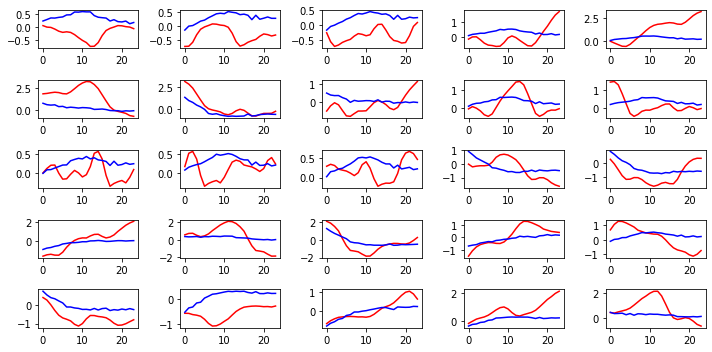

Step: 0, Train Loss: 0.4816415309906006
Step: 20, Train Loss: 0.46109557151794434
Step: 40, Train Loss: 0.4587644040584564
Step: 60, Train Loss: 0.33005279302597046
Step: 80, Train Loss: 0.5182846784591675
Step: 100, Train Loss: 0.5934844017028809
Step: 120, Train Loss: 0.4594449996948242
Step: 140, Train Loss: 0.5571416020393372
Epoch: 2, Train loss: 0.4567304941481107
acskill_socre:18.823740910467478, rmse_score:18.865117802320093
Epoch: 2, Valid Score: -0.041376891852614506


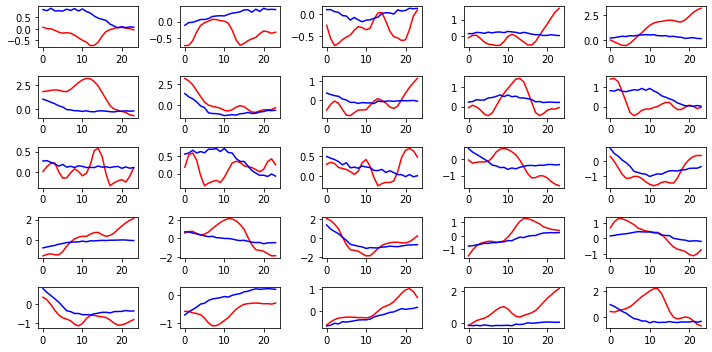

Step: 0, Train Loss: 0.3301885426044464
Step: 20, Train Loss: 0.31778275966644287
Step: 40, Train Loss: 0.2425619661808014
Step: 60, Train Loss: 0.34178704023361206
Step: 80, Train Loss: 0.3621465563774109
Step: 100, Train Loss: 0.4092382788658142
Step: 120, Train Loss: 0.3646693825721741
Step: 140, Train Loss: 0.3485632836818695
Epoch: 3, Train loss: 0.33953226388317265
acskill_socre:18.860459056909594, rmse_score:18.84791193887508
Epoch: 3, Valid Score: 0.012547118034515137


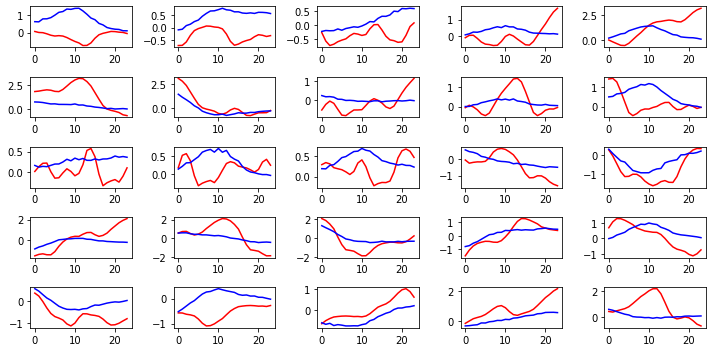

Step: 0, Train Loss: 0.38598737120628357
Step: 20, Train Loss: 0.3752341866493225
Step: 40, Train Loss: 0.1765405237674713
Step: 60, Train Loss: 0.18744084239006042
Step: 80, Train Loss: 0.16870498657226562
Step: 100, Train Loss: 0.21377164125442505
Step: 120, Train Loss: 0.2559767961502075
Step: 140, Train Loss: 0.2204338014125824
Epoch: 4, Train loss: 0.2183266284122859
acskill_socre:17.680630183387805, rmse_score:21.1862666643478
Epoch: 4, Valid Score: -3.5056364809599962


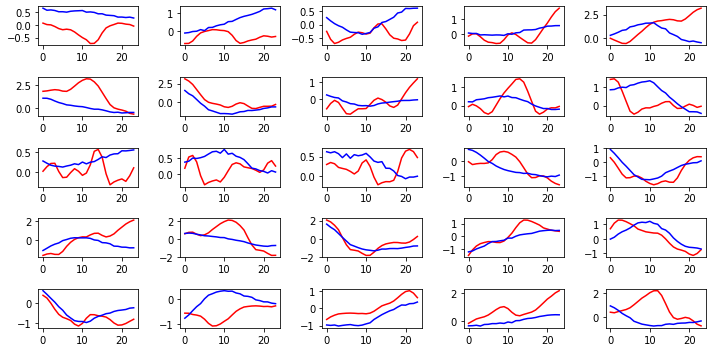

Step: 0, Train Loss: 0.22624270617961884
Step: 20, Train Loss: 0.13924524188041687
Step: 40, Train Loss: 0.1786257028579712
Step: 60, Train Loss: 0.10991492122411728
Step: 80, Train Loss: 0.17616724967956543
Step: 100, Train Loss: 0.17007100582122803
Step: 120, Train Loss: 0.2086360901594162
Step: 140, Train Loss: 0.12340149283409119
Epoch: 5, Train loss: 0.1556667608961667
acskill_socre:15.349852146435417, rmse_score:20.13270355394251
Epoch: 5, Valid Score: -4.782851407507092


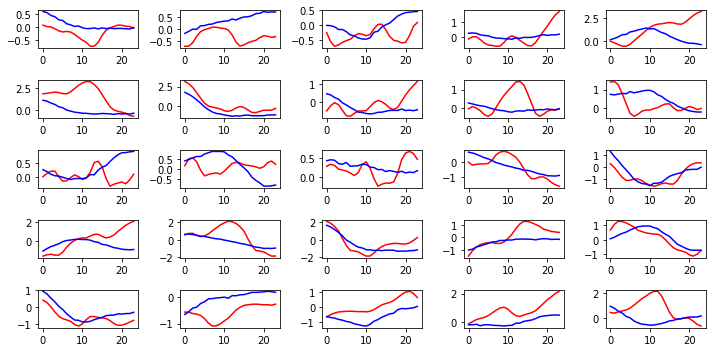

Step: 0, Train Loss: 0.11904266476631165
Step: 20, Train Loss: 0.09396395087242126
Step: 40, Train Loss: 0.09999623894691467
Step: 60, Train Loss: 0.11681656539440155
Step: 80, Train Loss: 0.09473081678152084
Step: 100, Train Loss: 0.08879734575748444
Step: 120, Train Loss: 0.17311322689056396
Step: 140, Train Loss: 0.10199998319149017
Epoch: 6, Train loss: 0.12221567654242255
acskill_socre:19.973311613828372, rmse_score:20.45849164842659
Epoch: 6, Valid Score: -0.4851800345982191


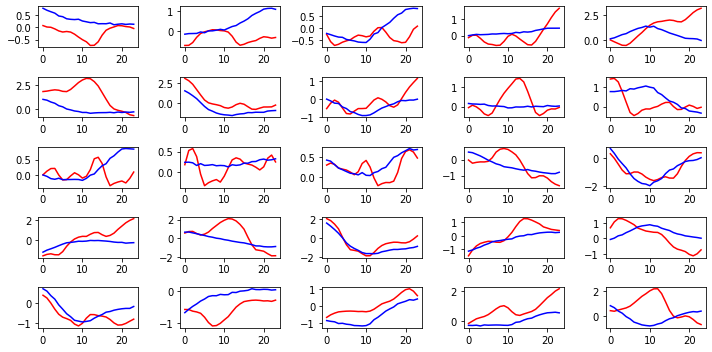

Step: 0, Train Loss: 0.09899686276912689
Step: 20, Train Loss: 0.08057714998722076
Step: 40, Train Loss: 0.0944097489118576
Step: 60, Train Loss: 0.09133012592792511
Step: 80, Train Loss: 0.08408463001251221
Step: 100, Train Loss: 0.09504394978284836
Step: 120, Train Loss: 0.08590497821569443
Step: 140, Train Loss: 0.09617122262716293
Epoch: 7, Train loss: 0.10715224476505632
acskill_socre:17.40023913901903, rmse_score:19.93124516437274
Epoch: 7, Valid Score: -2.5310060253537117


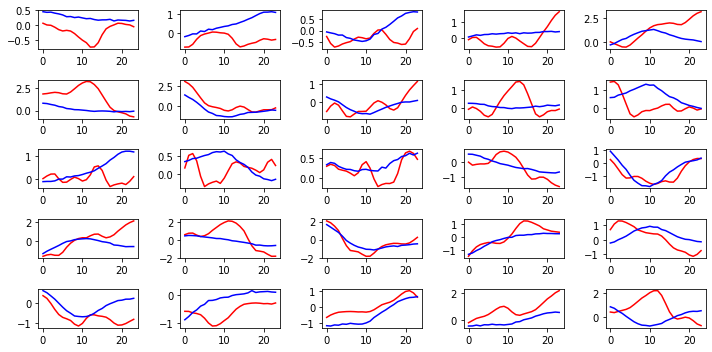

Step: 0, Train Loss: 0.12394630908966064
Step: 20, Train Loss: 0.12610583007335663
Step: 40, Train Loss: 0.07021643221378326
Step: 60, Train Loss: 0.1651756465435028
Step: 80, Train Loss: 0.06767018884420395
Step: 100, Train Loss: 0.12237812578678131
Step: 120, Train Loss: 0.10647207498550415
Step: 140, Train Loss: 0.07623493671417236
Epoch: 8, Train loss: 0.09930308538246645
acskill_socre:22.549846119639227, rmse_score:20.34601913418935
Epoch: 8, Valid Score: 2.2038269854498758
Model saved successfully


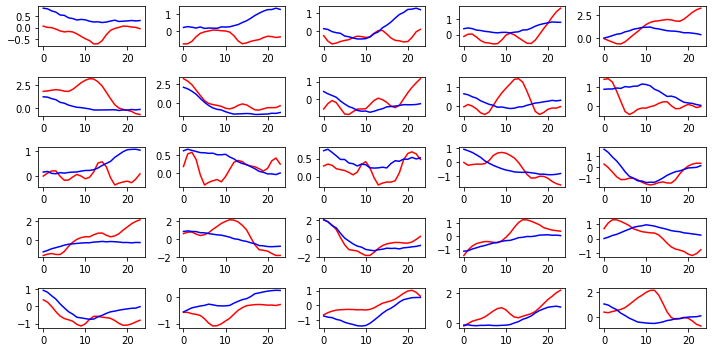

Step: 0, Train Loss: 0.06293060630559921
Step: 20, Train Loss: 0.12713377177715302
Step: 40, Train Loss: 0.08904765546321869
Step: 60, Train Loss: 0.07563398778438568
Step: 80, Train Loss: 0.07261165976524353
Step: 100, Train Loss: 0.08524128794670105
Step: 120, Train Loss: 0.08310350030660629
Step: 140, Train Loss: 0.09898386895656586
Epoch: 9, Train loss: 0.09353765562074641
acskill_socre:18.37112260127339, rmse_score:20.149352545321136
Epoch: 9, Valid Score: -1.7782299440477445


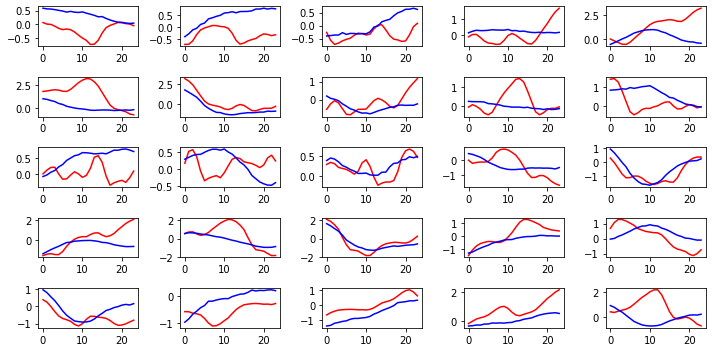

Step: 0, Train Loss: 0.0694364607334137
Step: 20, Train Loss: 0.08095329999923706
Step: 40, Train Loss: 0.10629969835281372
Step: 60, Train Loss: 0.06351789832115173
Step: 80, Train Loss: 0.07030661404132843
Step: 100, Train Loss: 0.07654912024736404
Step: 120, Train Loss: 0.10906969010829926
Step: 140, Train Loss: 0.08208423852920532
Epoch: 10, Train loss: 0.08836727007611157
acskill_socre:20.31620155160668, rmse_score:20.84370945389157
Epoch: 10, Valid Score: -0.5275079022848885


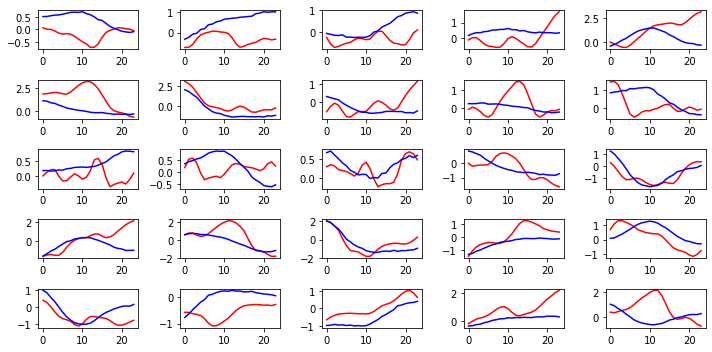

Step: 0, Train Loss: 0.1056889146566391
Step: 20, Train Loss: 0.0734391063451767
Step: 40, Train Loss: 0.07396306097507477
Step: 60, Train Loss: 0.07673698663711548
Step: 80, Train Loss: 0.08171877264976501
Step: 100, Train Loss: 0.07501089572906494
Step: 120, Train Loss: 0.10127478837966919
Step: 140, Train Loss: 0.08765378594398499
Epoch: 11, Train loss: 0.08496226944437582
acskill_socre:20.975901478562292, rmse_score:19.67223225308695
Epoch: 11, Valid Score: 1.3036692254753426


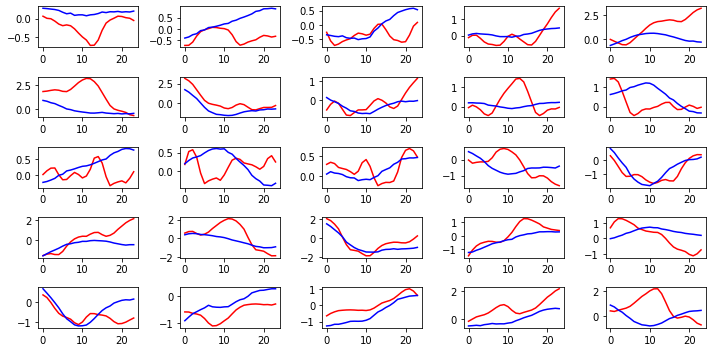

Step: 0, Train Loss: 0.09242425858974457
Step: 20, Train Loss: 0.057011038064956665
Step: 40, Train Loss: 0.09585367888212204
Step: 60, Train Loss: 0.06723761558532715
Step: 80, Train Loss: 0.06673677265644073
Step: 100, Train Loss: 0.09171389788389206
Step: 120, Train Loss: 0.06998082250356674
Step: 140, Train Loss: 0.06589369475841522
Epoch: 12, Train loss: 0.07954680475674264
acskill_socre:19.326299513279206, rmse_score:19.27664516938473
Epoch: 12, Valid Score: 0.04965434389447765


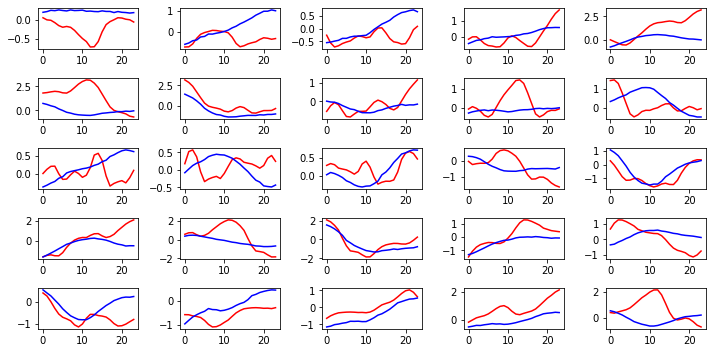

Step: 0, Train Loss: 0.09453663229942322
Step: 20, Train Loss: 0.08356335014104843
Step: 40, Train Loss: 0.0602872334420681
Step: 60, Train Loss: 0.08696243166923523
Step: 80, Train Loss: 0.09589385986328125
Step: 100, Train Loss: 0.06755471229553223
Step: 120, Train Loss: 0.06451982259750366
Step: 140, Train Loss: 0.09958281368017197
Epoch: 13, Train loss: 0.0787454538353502
acskill_socre:17.481078045996675, rmse_score:21.060044889871193
Epoch: 13, Valid Score: -3.578966843874518


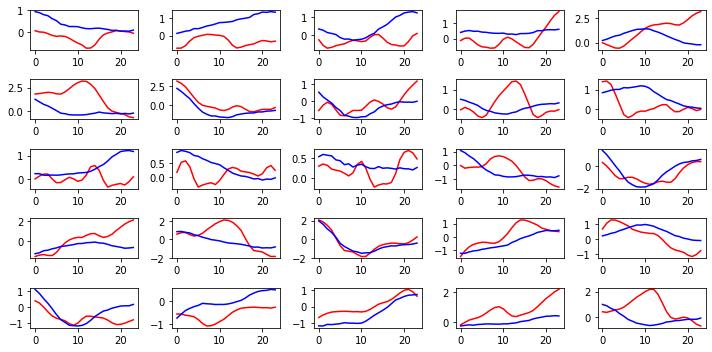

Step: 0, Train Loss: 0.06160959601402283
Step: 20, Train Loss: 0.0656997412443161
Step: 40, Train Loss: 0.05791313201189041
Step: 60, Train Loss: 0.05738488957285881
Step: 80, Train Loss: 0.08130782842636108
Step: 100, Train Loss: 0.08222731947898865
Step: 120, Train Loss: 0.05581488460302353
Step: 140, Train Loss: 0.06384444236755371
Epoch: 14, Train loss: 0.07444657063851617
acskill_socre:16.70747636497571, rmse_score:20.78167878941261
Epoch: 14, Valid Score: -4.074202424436898


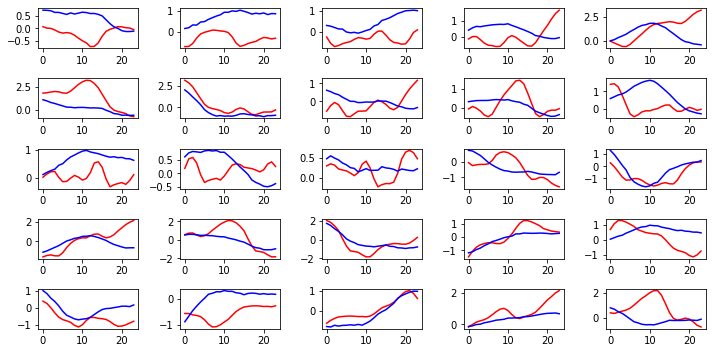

Step: 0, Train Loss: 0.0737873837351799
Step: 20, Train Loss: 0.07095800340175629
Step: 40, Train Loss: 0.07082199305295944
Step: 60, Train Loss: 0.08054500073194504
Step: 80, Train Loss: 0.0669403001666069
Step: 100, Train Loss: 0.07313914597034454
Step: 120, Train Loss: 0.05529845878481865
Step: 140, Train Loss: 0.057400986552238464
Epoch: 15, Train loss: 0.06865365040322689
acskill_socre:17.983340175004056, rmse_score:19.914801249572974
Epoch: 15, Valid Score: -1.9314610745689187


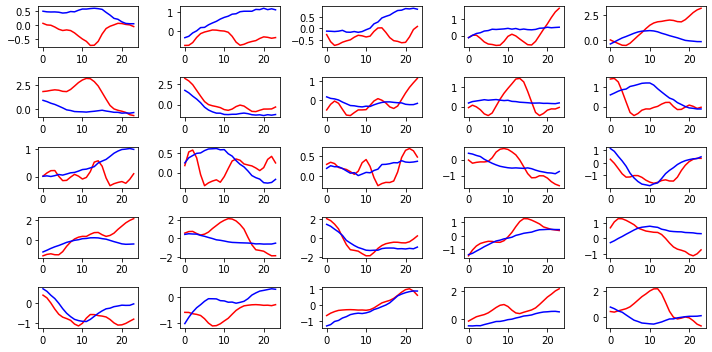

Step: 0, Train Loss: 0.08378561586141586
Step: 20, Train Loss: 0.08600325882434845
Step: 40, Train Loss: 0.07697273790836334
Step: 60, Train Loss: 0.05954986810684204
Step: 80, Train Loss: 0.06087857484817505
Step: 100, Train Loss: 0.0688556581735611
Step: 120, Train Loss: 0.05982543155550957
Step: 140, Train Loss: 0.0425439290702343
Epoch: 16, Train loss: 0.06510080716075146
acskill_socre:14.403508520989472, rmse_score:19.91805412472075
Epoch: 16, Valid Score: -5.514545603731278


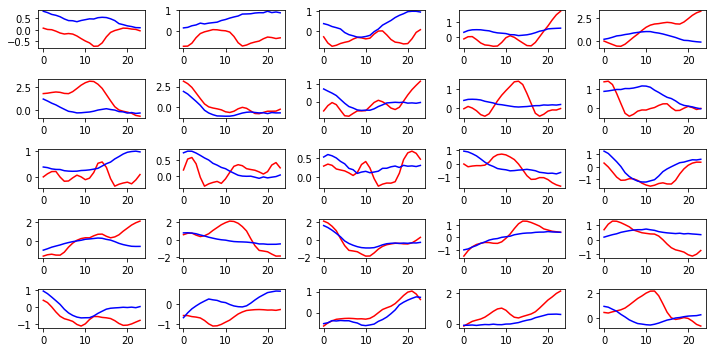

Step: 0, Train Loss: 0.04725555330514908
Step: 20, Train Loss: 0.05899186059832573
Step: 40, Train Loss: 0.08685556054115295
Step: 60, Train Loss: 0.0769369900226593
Step: 80, Train Loss: 0.08976604789495468
Step: 100, Train Loss: 0.056205131113529205
Step: 120, Train Loss: 0.048778973519802094
Step: 140, Train Loss: 0.0703514963388443
Epoch: 17, Train loss: 0.06215637136403829
acskill_socre:18.652799806269414, rmse_score:19.480301159757907
Epoch: 17, Valid Score: -0.8275013534884934


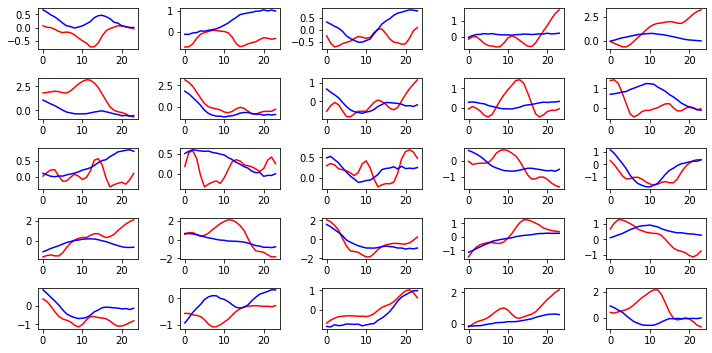

Step: 0, Train Loss: 0.046745531260967255
Step: 20, Train Loss: 0.05366247147321701
Step: 40, Train Loss: 0.04330834746360779
Step: 60, Train Loss: 0.05951559543609619
Step: 80, Train Loss: 0.04394932836294174
Step: 100, Train Loss: 0.05963943526148796
Step: 120, Train Loss: 0.04230533167719841
Step: 140, Train Loss: 0.04938875138759613
Epoch: 18, Train loss: 0.05946557267173512
acskill_socre:16.685403760131646, rmse_score:19.75708193280156
Epoch: 18, Valid Score: -3.071678172669916


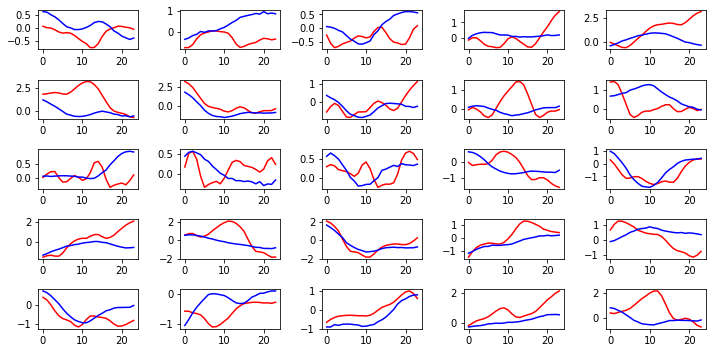

Step: 0, Train Loss: 0.058978911489248276
Step: 20, Train Loss: 0.06903442740440369
Step: 40, Train Loss: 0.07219983637332916
Step: 60, Train Loss: 0.05408066511154175
Step: 80, Train Loss: 0.05978047102689743
Step: 100, Train Loss: 0.06639820337295532
Step: 120, Train Loss: 0.048196595162153244
Step: 140, Train Loss: 0.060869231820106506
Epoch: 19, Train loss: 0.056306053055067584
acskill_socre:18.03892609478649, rmse_score:19.38429283087278
Epoch: 19, Valid Score: -1.3453667360862909


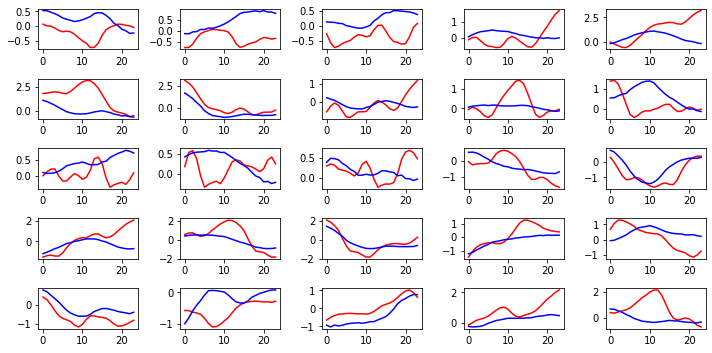

Step: 0, Train Loss: 0.0486225001513958
Step: 20, Train Loss: 0.04257269203662872
Step: 40, Train Loss: 0.0399792343378067
Step: 60, Train Loss: 0.046268608421087265
Step: 80, Train Loss: 0.060250602662563324
Step: 100, Train Loss: 0.04666857048869133
Step: 120, Train Loss: 0.05776625871658325
Step: 140, Train Loss: 0.06812750548124313
Epoch: 20, Train loss: 0.05255927505252296
acskill_socre:19.327550351505643, rmse_score:19.852941953730834
Epoch: 20, Valid Score: -0.5253916022251914


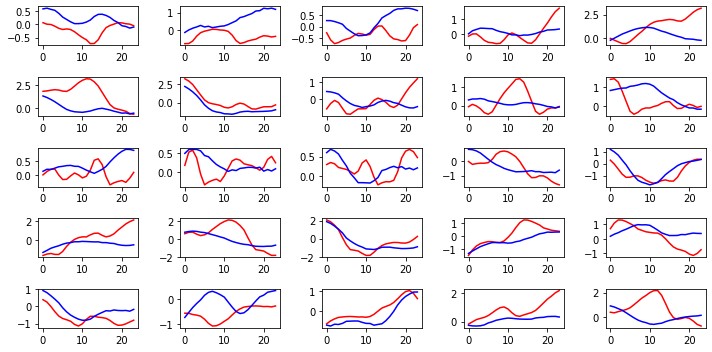

Step: 0, Train Loss: 0.05153922736644745
Step: 20, Train Loss: 0.0542166642844677
Step: 40, Train Loss: 0.041397325694561005
Step: 60, Train Loss: 0.05136740207672119
Step: 80, Train Loss: 0.033515170216560364
Step: 100, Train Loss: 0.04857224225997925
Step: 120, Train Loss: 0.04139482229948044
Step: 140, Train Loss: 0.04874014854431152
Epoch: 21, Train loss: 0.052599866963820914
acskill_socre:15.851291372470122, rmse_score:20.135423185972407
Epoch: 21, Valid Score: -4.284131813502285


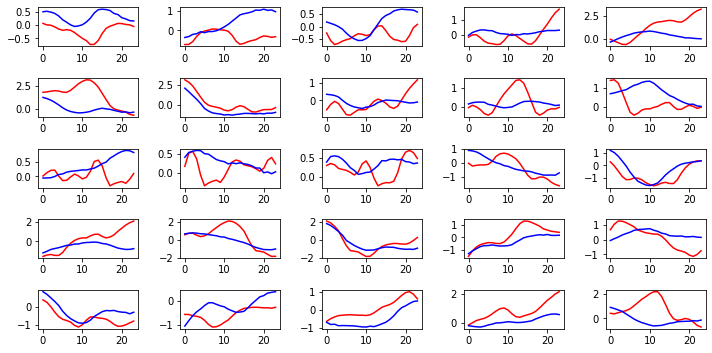

Step: 0, Train Loss: 0.07263118028640747
Step: 20, Train Loss: 0.05166621506214142
Step: 40, Train Loss: 0.05530542880296707
Step: 60, Train Loss: 0.049166515469551086
Step: 80, Train Loss: 0.04156646877527237
Step: 100, Train Loss: 0.04301360249519348
Step: 120, Train Loss: 0.058201905339956284
Step: 140, Train Loss: 0.051102906465530396
Epoch: 22, Train loss: 0.04959844236504542
acskill_socre:16.209960105765614, rmse_score:19.728052205161237
Epoch: 22, Valid Score: -3.5180920993956235


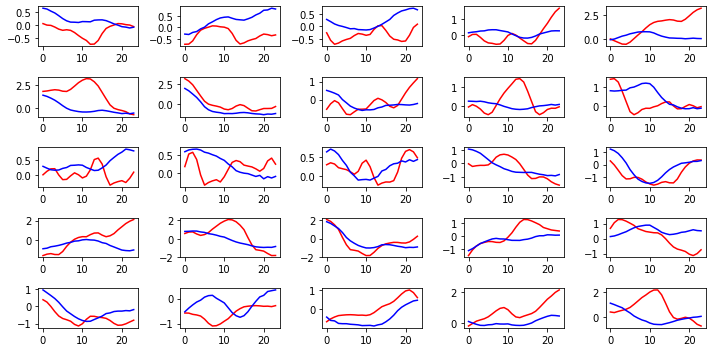

Step: 0, Train Loss: 0.04281073063611984
Step: 20, Train Loss: 0.037402767688035965
Step: 40, Train Loss: 0.03644473850727081
Step: 60, Train Loss: 0.03362733870744705
Step: 80, Train Loss: 0.04227495193481445
Step: 100, Train Loss: 0.06829479336738586
Step: 120, Train Loss: 0.074417844414711
Step: 140, Train Loss: 0.03189228102564812
Epoch: 23, Train loss: 0.04623660922356664
acskill_socre:18.442854941858556, rmse_score:18.908029562419557
Epoch: 23, Valid Score: -0.465174620561001


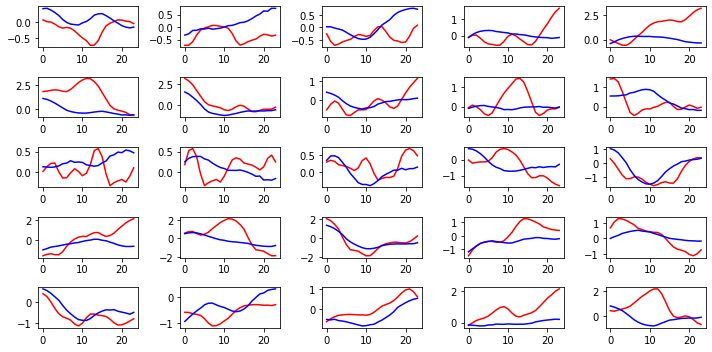

Step: 0, Train Loss: 0.05606098100543022
Step: 20, Train Loss: 0.05025836080312729
Step: 40, Train Loss: 0.08460026979446411
Step: 60, Train Loss: 0.05664893239736557
Step: 80, Train Loss: 0.031370338052511215
Step: 100, Train Loss: 0.05288320779800415
Step: 120, Train Loss: 0.06081840395927429
Step: 140, Train Loss: 0.06410381197929382
Epoch: 24, Train loss: 0.04570055772129395
acskill_socre:19.667753035065324, rmse_score:19.559129406980965
Epoch: 24, Valid Score: 0.10862362808435932


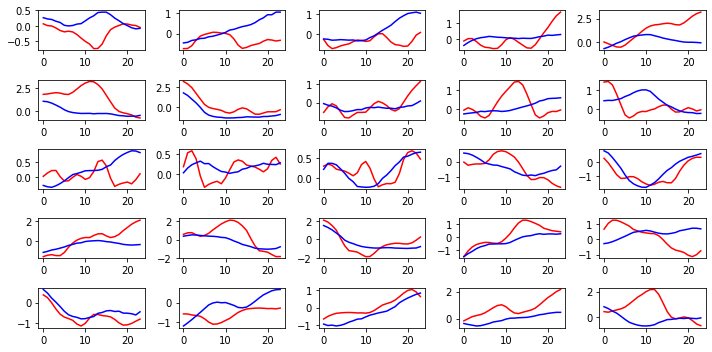

Step: 0, Train Loss: 0.04969000071287155
Step: 20, Train Loss: 0.051909469068050385
Step: 40, Train Loss: 0.06672798097133636
Step: 60, Train Loss: 0.03648815676569939
Step: 80, Train Loss: 0.049094460904598236
Step: 100, Train Loss: 0.03841448575258255
Step: 120, Train Loss: 0.05497640371322632
Step: 140, Train Loss: 0.04387803375720978
Epoch: 25, Train loss: 0.04577545569061416
acskill_socre:17.91198832182003, rmse_score:21.009646493755575
Epoch: 25, Valid Score: -3.097658171935546


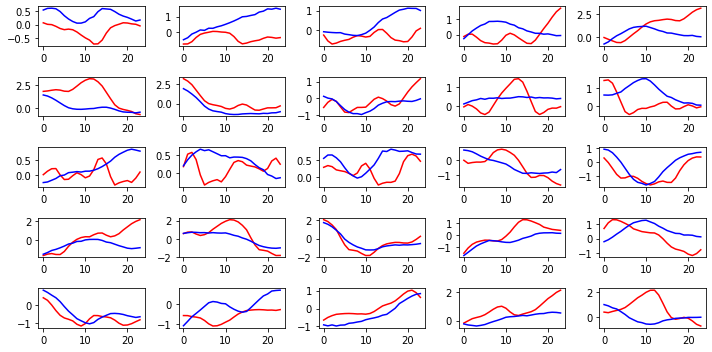

Step: 0, Train Loss: 0.04596436023712158
Step: 20, Train Loss: 0.05260532349348068
Step: 40, Train Loss: 0.04778354987502098
Step: 60, Train Loss: 0.06466937065124512
Step: 80, Train Loss: 0.05196630209684372
Step: 100, Train Loss: 0.04640920087695122
Step: 120, Train Loss: 0.03371976688504219
Step: 140, Train Loss: 0.034781645983457565
Epoch: 26, Train loss: 0.04339660452806378
acskill_socre:17.93625021044619, rmse_score:19.239484001404797
Epoch: 26, Valid Score: -1.3032337909586076


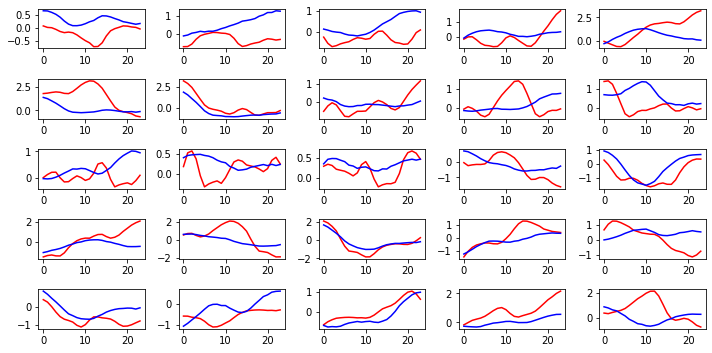

Step: 0, Train Loss: 0.05575473606586456
Step: 20, Train Loss: 0.05064929649233818
Step: 40, Train Loss: 0.03213759511709213
Step: 60, Train Loss: 0.04714803397655487
Step: 80, Train Loss: 0.035595595836639404
Step: 100, Train Loss: 0.060992442071437836
Step: 120, Train Loss: 0.039843033999204636
Step: 140, Train Loss: 0.04470064863562584
Epoch: 27, Train loss: 0.04252278843052583
acskill_socre:14.838424747665872, rmse_score:19.437203186699918
Epoch: 27, Valid Score: -4.598778439034046


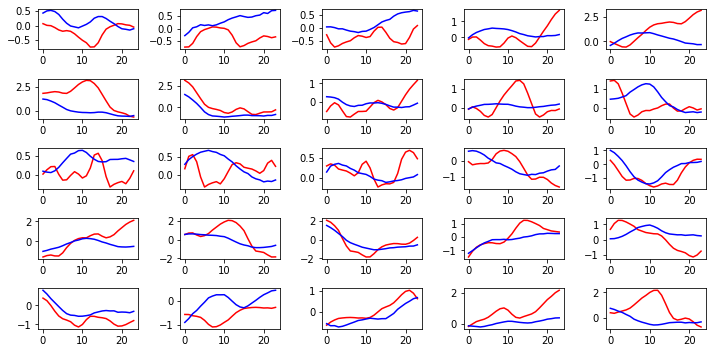

Step: 0, Train Loss: 0.0399349182844162
Step: 20, Train Loss: 0.0372677817940712
Step: 40, Train Loss: 0.050816141068935394
Step: 60, Train Loss: 0.037216782569885254
Step: 80, Train Loss: 0.0372956246137619
Step: 100, Train Loss: 0.0321657769382
Step: 120, Train Loss: 0.03192272037267685
Step: 140, Train Loss: 0.032900840044021606
Epoch: 28, Train loss: 0.04167199858196386
acskill_socre:20.315460459819832, rmse_score:18.91742257358747
Epoch: 28, Valid Score: 1.3980378862323626


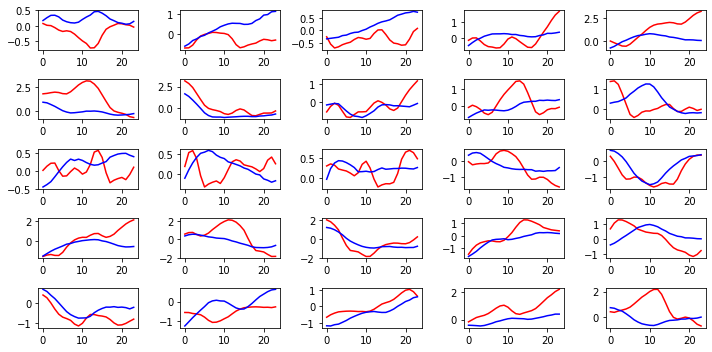

Step: 0, Train Loss: 0.05155361816287041
Step: 20, Train Loss: 0.03198075667023659
Step: 40, Train Loss: 0.03758788853883743
Step: 60, Train Loss: 0.03182601556181908
Step: 80, Train Loss: 0.03762994706630707
Step: 100, Train Loss: 0.04115988686680794
Step: 120, Train Loss: 0.03642813861370087
Step: 140, Train Loss: 0.04264553636312485
Epoch: 29, Train loss: 0.040640514420524035
acskill_socre:14.95022688610977, rmse_score:20.471065634948282
Epoch: 29, Valid Score: -5.5208387488385124


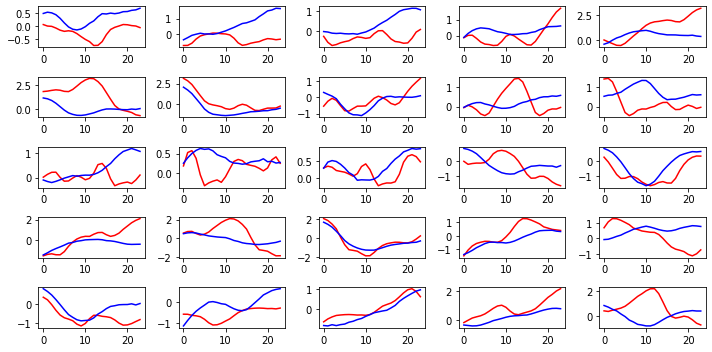

Step: 0, Train Loss: 0.03676426410675049
Step: 20, Train Loss: 0.035143833607435226
Step: 40, Train Loss: 0.03431461378931999
Step: 60, Train Loss: 0.05798273906111717
Step: 80, Train Loss: 0.04045133665204048
Step: 100, Train Loss: 0.028735866770148277
Step: 120, Train Loss: 0.03913652524352074
Step: 140, Train Loss: 0.036139748990535736
Epoch: 30, Train loss: 0.03802696966298231
acskill_socre:18.29903120103652, rmse_score:19.282742063433336
Epoch: 30, Valid Score: -0.9837108623968156


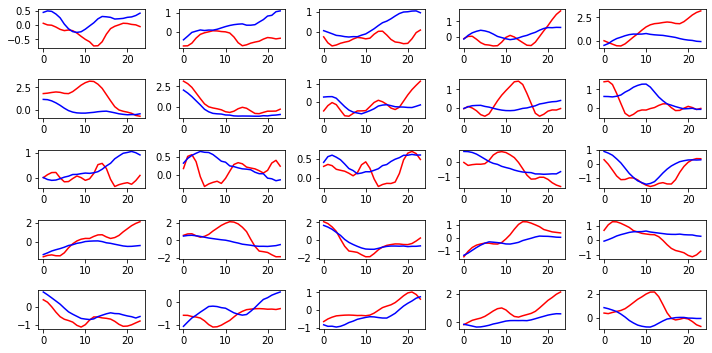

Step: 0, Train Loss: 0.048775166273117065
Step: 20, Train Loss: 0.05440070852637291
Step: 40, Train Loss: 0.031940482556819916
Step: 60, Train Loss: 0.038328785449266434
Step: 80, Train Loss: 0.03657064586877823
Step: 100, Train Loss: 0.04274175316095352
Step: 120, Train Loss: 0.03623497858643532
Step: 140, Train Loss: 0.029333224520087242
Epoch: 31, Train loss: 0.037244937995014944
acskill_socre:16.957709733349972, rmse_score:19.70717150947427
Epoch: 31, Valid Score: -2.749461776124299


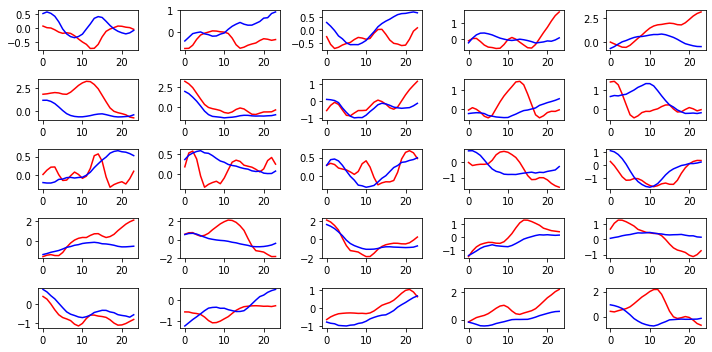

Step: 0, Train Loss: 0.0317896232008934
Step: 20, Train Loss: 0.041291218250989914
Step: 40, Train Loss: 0.03383026644587517
Step: 60, Train Loss: 0.03356124460697174
Step: 80, Train Loss: 0.04415256902575493
Step: 100, Train Loss: 0.03922579437494278
Step: 120, Train Loss: 0.03339704871177673
Step: 140, Train Loss: 0.024766355752944946
Epoch: 32, Train loss: 0.03650179681406446
acskill_socre:19.103142816666487, rmse_score:19.524437733438532
Epoch: 32, Valid Score: -0.42129491677204456


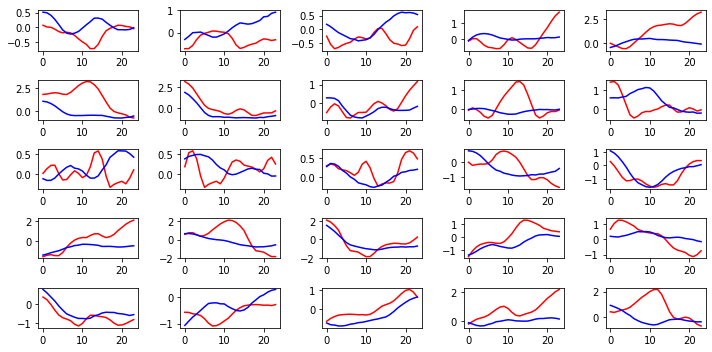

Step: 0, Train Loss: 0.043394021689891815
Step: 20, Train Loss: 0.05540023371577263
Step: 40, Train Loss: 0.03443034738302231
Step: 60, Train Loss: 0.03128734976053238
Step: 80, Train Loss: 0.030879950150847435
Step: 100, Train Loss: 0.0392446406185627
Step: 120, Train Loss: 0.04134146496653557
Step: 140, Train Loss: 0.029744386672973633
Epoch: 33, Train loss: 0.03548788905705083
acskill_socre:15.371093989912094, rmse_score:19.529832596568397
Epoch: 33, Valid Score: -4.1587386066563035


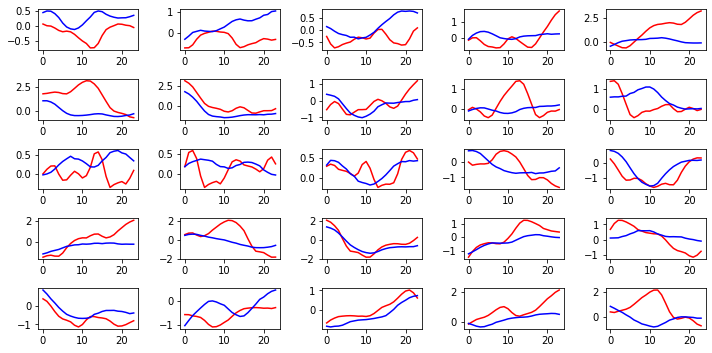

Step: 0, Train Loss: 0.029727935791015625
Step: 20, Train Loss: 0.031102215871214867
Step: 40, Train Loss: 0.03593296557664871
Step: 60, Train Loss: 0.029973026365041733
Step: 80, Train Loss: 0.030712544918060303
Step: 100, Train Loss: 0.029211390763521194
Step: 120, Train Loss: 0.025163274258375168
Step: 140, Train Loss: 0.034824058413505554
Epoch: 34, Train loss: 0.03482483698642009
acskill_socre:16.919787678158066, rmse_score:19.624239289041004
Epoch: 34, Valid Score: -2.7044516108829377


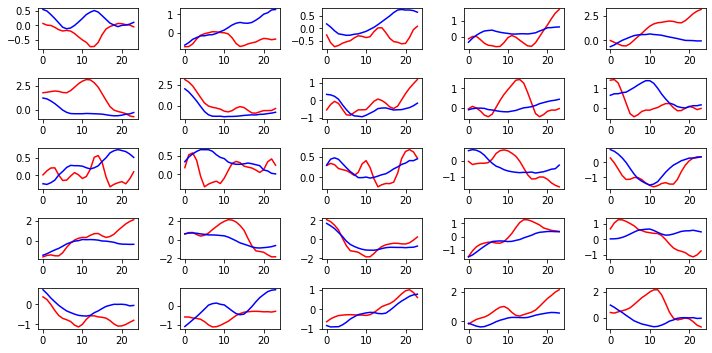

Step: 0, Train Loss: 0.029609253630042076
Step: 20, Train Loss: 0.02754206955432892
Step: 40, Train Loss: 0.030300822108983994
Step: 60, Train Loss: 0.03346269950270653
Step: 80, Train Loss: 0.02794541046023369
Step: 100, Train Loss: 0.03593093901872635
Step: 120, Train Loss: 0.028948843479156494
Step: 140, Train Loss: 0.02788117155432701
Epoch: 35, Train loss: 0.03355696824162382
acskill_socre:14.498132208980495, rmse_score:19.374169505866448
Epoch: 35, Valid Score: -4.876037296885952


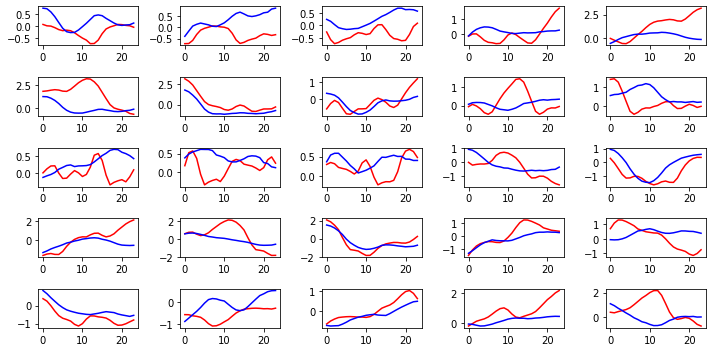

Step: 0, Train Loss: 0.04697088897228241
Step: 20, Train Loss: 0.042938485741615295
Step: 40, Train Loss: 0.027863003313541412
Step: 60, Train Loss: 0.042137645184993744
Step: 80, Train Loss: 0.030669694766402245
Step: 100, Train Loss: 0.02927684597671032
Step: 120, Train Loss: 0.037362899631261826
Step: 140, Train Loss: 0.02871819958090782
Epoch: 36, Train loss: 0.03212877539024778
acskill_socre:17.878656359087543, rmse_score:19.605153670871527
Epoch: 36, Valid Score: -1.7264973117839837


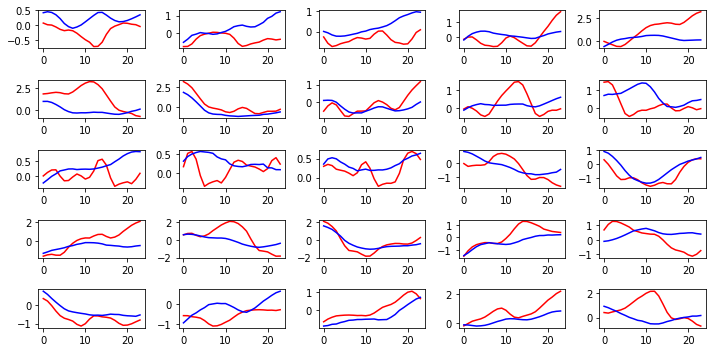

Step: 0, Train Loss: 0.030074279755353928
Step: 20, Train Loss: 0.030899181962013245
Step: 40, Train Loss: 0.02832392416894436
Step: 60, Train Loss: 0.02527749538421631
Step: 80, Train Loss: 0.03251557797193527
Step: 100, Train Loss: 0.032701604068279266
Step: 120, Train Loss: 0.037835706025362015
Step: 140, Train Loss: 0.03422335535287857
Epoch: 37, Train loss: 0.03136161797718234
acskill_socre:13.754860769792865, rmse_score:19.65760306534026
Epoch: 37, Valid Score: -5.902742295547396


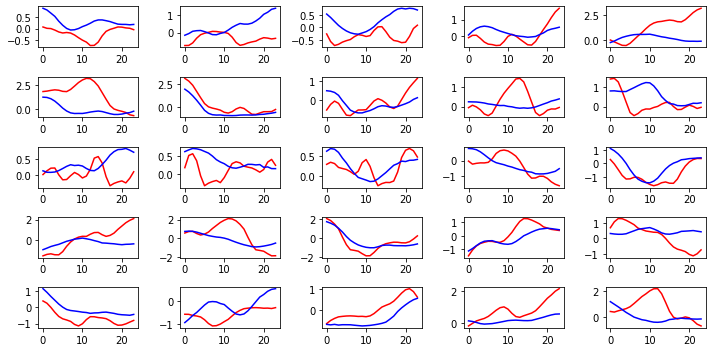

Step: 0, Train Loss: 0.03372678905725479
Step: 20, Train Loss: 0.031091880053281784
Step: 40, Train Loss: 0.02377147041261196
Step: 60, Train Loss: 0.028940409421920776
Step: 80, Train Loss: 0.03369992598891258
Step: 100, Train Loss: 0.025907596573233604
Step: 120, Train Loss: 0.023425962775945663
Step: 140, Train Loss: 0.023219700902700424
Epoch: 38, Train loss: 0.029902135608845377
acskill_socre:18.503335053776915, rmse_score:19.411400920409246
Epoch: 38, Valid Score: -0.9080658666323309


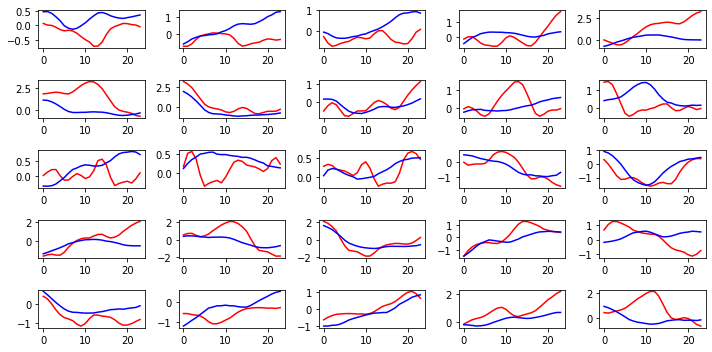

Step: 0, Train Loss: 0.022884059697389603
Step: 20, Train Loss: 0.0370192751288414
Step: 40, Train Loss: 0.030971884727478027
Step: 60, Train Loss: 0.02399950847029686
Step: 80, Train Loss: 0.022895272821187973
Step: 100, Train Loss: 0.028693554922938347
Step: 120, Train Loss: 0.042516082525253296
Step: 140, Train Loss: 0.029714947566390038
Epoch: 39, Train loss: 0.028857396736945193
acskill_socre:14.34306879417019, rmse_score:19.239999285268834
Epoch: 39, Valid Score: -4.896930491098644


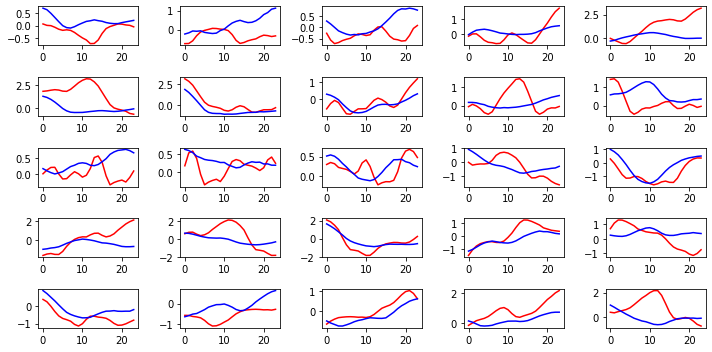

Step: 0, Train Loss: 0.023324355483055115
Step: 20, Train Loss: 0.02495846152305603
Step: 40, Train Loss: 0.022255536168813705
Step: 60, Train Loss: 0.02479352056980133
Step: 80, Train Loss: 0.02654080092906952
Step: 100, Train Loss: 0.028675731271505356
Step: 120, Train Loss: 0.032090649008750916
Step: 140, Train Loss: 0.025784490630030632
Epoch: 40, Train loss: 0.029334848198070102
acskill_socre:17.062009742422212, rmse_score:18.805230339441966
Epoch: 40, Valid Score: -1.7432205970197536


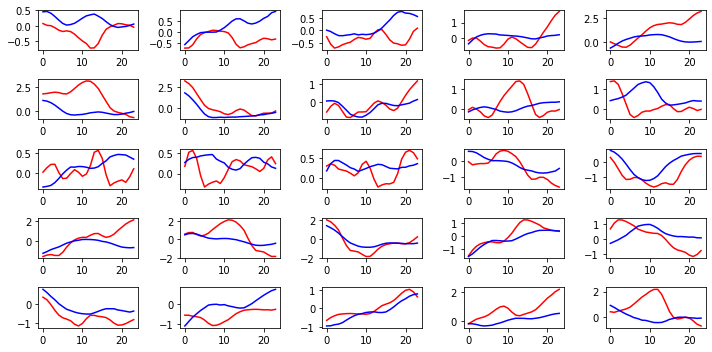

Step: 0, Train Loss: 0.02850862219929695
Step: 20, Train Loss: 0.021536383777856827
Step: 40, Train Loss: 0.021787624806165695
Step: 60, Train Loss: 0.02860414609313011
Step: 80, Train Loss: 0.03541671857237816
Step: 100, Train Loss: 0.024126321077346802
Step: 120, Train Loss: 0.028737150132656097
Step: 140, Train Loss: 0.032324861735105515
Epoch: 41, Train loss: 0.029814181798329092
acskill_socre:13.65998763996752, rmse_score:19.041602561455093
Epoch: 41, Valid Score: -5.381614921487573


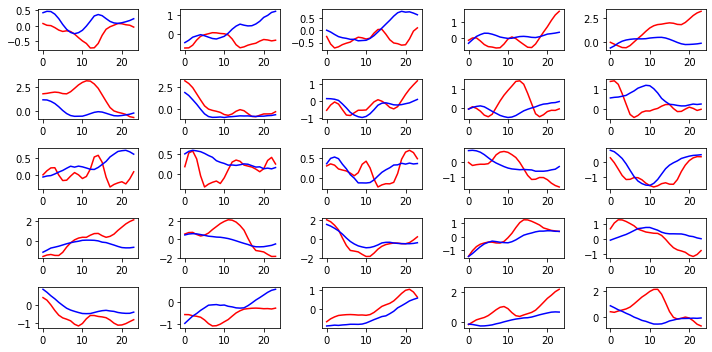

Step: 0, Train Loss: 0.03460382670164108
Step: 20, Train Loss: 0.028109660372138023
Step: 40, Train Loss: 0.03066316246986389
Step: 60, Train Loss: 0.04255498945713043
Step: 80, Train Loss: 0.03014795482158661
Step: 100, Train Loss: 0.022534629330039024
Step: 120, Train Loss: 0.030870791524648666
Step: 140, Train Loss: 0.029136773198843002
Epoch: 42, Train loss: 0.02868610916480626
acskill_socre:12.138790823933096, rmse_score:19.66669425577328
Epoch: 42, Valid Score: -7.527903431840183


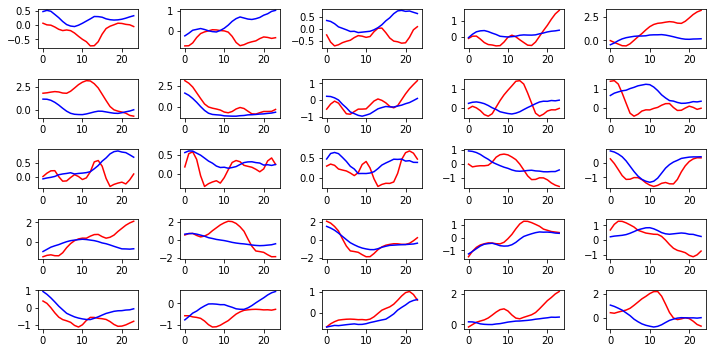

Step: 0, Train Loss: 0.02846507355570793
Step: 20, Train Loss: 0.021023821085691452
Step: 40, Train Loss: 0.026157423853874207
Step: 60, Train Loss: 0.026693662628531456
Step: 80, Train Loss: 0.026184342801570892
Step: 100, Train Loss: 0.027203425765037537
Step: 120, Train Loss: 0.02015838399529457
Step: 140, Train Loss: 0.027479134500026703
Epoch: 43, Train loss: 0.02750180086299573
acskill_socre:16.04894489085429, rmse_score:19.38082933192772
Epoch: 43, Valid Score: -3.3318844410734307


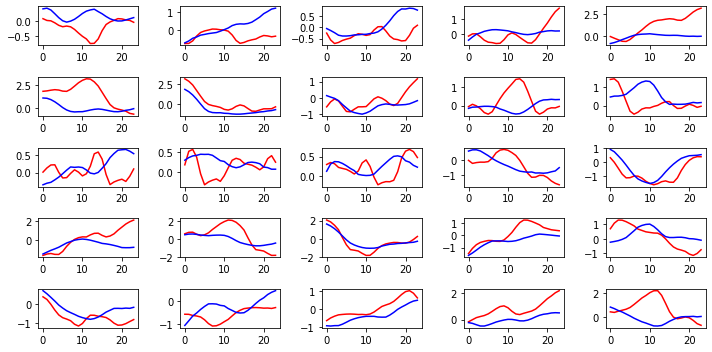

Step: 0, Train Loss: 0.028904816135764122
Step: 20, Train Loss: 0.030819885432720184
Step: 40, Train Loss: 0.02636561542749405
Step: 60, Train Loss: 0.03391733765602112
Step: 80, Train Loss: 0.025934364646673203
Step: 100, Train Loss: 0.02756146714091301
Step: 120, Train Loss: 0.019203156232833862
Step: 140, Train Loss: 0.02536427043378353
Epoch: 44, Train loss: 0.027899400739330952
acskill_socre:13.209635179191853, rmse_score:19.33253816760436
Epoch: 44, Valid Score: -6.1229029884125055


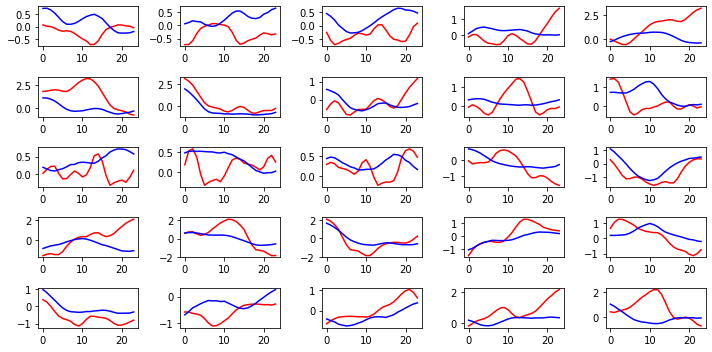

Step: 0, Train Loss: 0.035426925867795944
Step: 20, Train Loss: 0.02493465505540371
Step: 40, Train Loss: 0.036153703927993774
Step: 60, Train Loss: 0.01999686285853386
Step: 80, Train Loss: 0.016506437212228775
Step: 100, Train Loss: 0.03780697286128998
Step: 120, Train Loss: 0.018764538690447807
Step: 140, Train Loss: 0.029620464891195297
Epoch: 45, Train loss: 0.027498917947587086
acskill_socre:15.254363363893457, rmse_score:19.44068768164902
Epoch: 45, Valid Score: -4.186324317755563


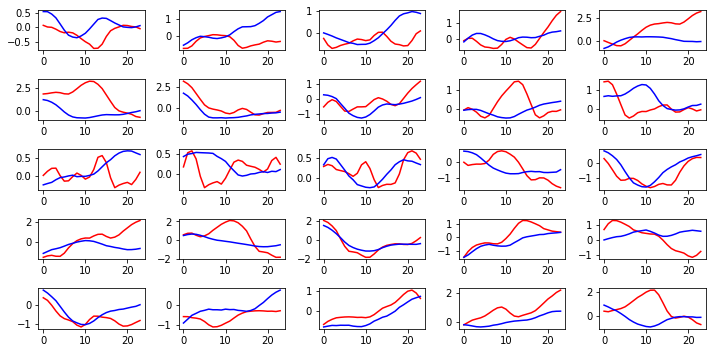

Step: 0, Train Loss: 0.027575885877013206
Step: 20, Train Loss: 0.02906195819377899
Step: 40, Train Loss: 0.039226971566677094
Step: 60, Train Loss: 0.02285056933760643
Step: 80, Train Loss: 0.024133941158652306
Step: 100, Train Loss: 0.027193333953619003
Step: 120, Train Loss: 0.023863760754466057
Step: 140, Train Loss: 0.024273483082652092
Epoch: 46, Train loss: 0.027018501066079694
acskill_socre:15.29590551450875, rmse_score:19.509314556296165
Epoch: 46, Valid Score: -4.213409041787415


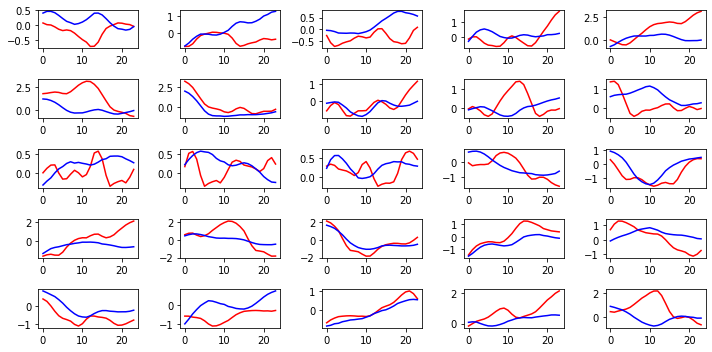

Step: 0, Train Loss: 0.026032015681266785
Step: 20, Train Loss: 0.021484151482582092
Step: 40, Train Loss: 0.01931316778063774
Step: 60, Train Loss: 0.03370456397533417
Step: 80, Train Loss: 0.024788683280348778
Step: 100, Train Loss: 0.03283794969320297
Step: 120, Train Loss: 0.028896203264594078
Step: 140, Train Loss: 0.023633016273379326
Epoch: 47, Train loss: 0.025806314120553946
acskill_socre:12.720525930009536, rmse_score:20.0226943685895
Epoch: 47, Valid Score: -7.302168438579965


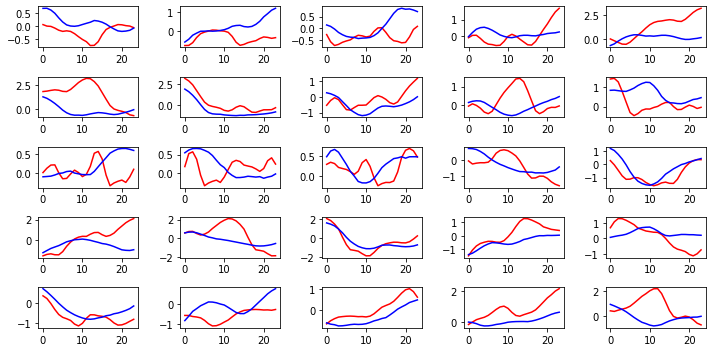

Step: 0, Train Loss: 0.01839371770620346
Step: 20, Train Loss: 0.03374465927481651
Step: 40, Train Loss: 0.03095557540655136
Step: 60, Train Loss: 0.017138559371232986
Step: 80, Train Loss: 0.023901693522930145
Step: 100, Train Loss: 0.027116160839796066
Step: 120, Train Loss: 0.01986987516283989
Step: 140, Train Loss: 0.023200927302241325
Epoch: 48, Train loss: 0.026444047459796685
acskill_socre:11.411814483572828, rmse_score:18.97431707959558
Epoch: 48, Valid Score: -7.562502596022751


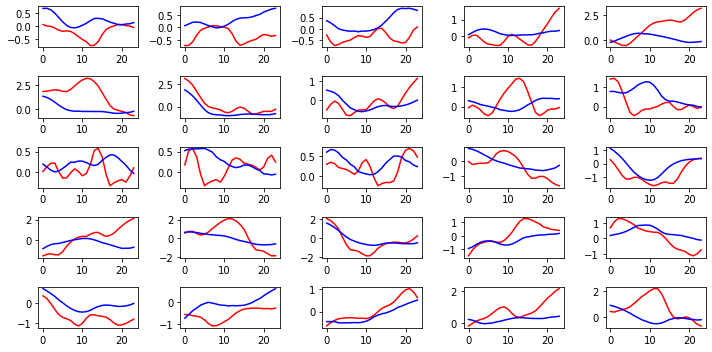

Step: 0, Train Loss: 0.02027139998972416
Step: 20, Train Loss: 0.027079269289970398
Step: 40, Train Loss: 0.02443944290280342
Step: 60, Train Loss: 0.03980705142021179
Step: 80, Train Loss: 0.024212941527366638
Step: 100, Train Loss: 0.028965413570404053
Step: 120, Train Loss: 0.028295569121837616
Step: 140, Train Loss: 0.022869205102324486
Epoch: 49, Train loss: 0.02735151527832224
acskill_socre:13.22769062070112, rmse_score:20.071428930032972
Epoch: 49, Valid Score: -6.843738309331853


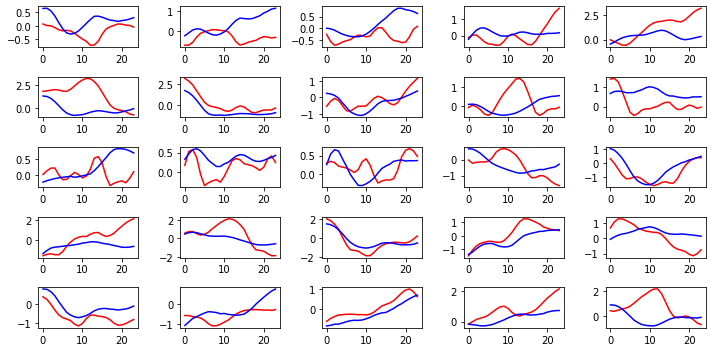

Step: 0, Train Loss: 0.033743202686309814
Step: 20, Train Loss: 0.027046984061598778
Step: 40, Train Loss: 0.026170488446950912
Step: 60, Train Loss: 0.02552804909646511
Step: 80, Train Loss: 0.02267175167798996
Step: 100, Train Loss: 0.026062896475195885
Step: 120, Train Loss: 0.027614213526248932
Step: 140, Train Loss: 0.0270112045109272
Epoch: 50, Train loss: 0.02891956538931556
acskill_socre:16.705289015251847, rmse_score:19.530811251530437
Epoch: 50, Valid Score: -2.825522236278591


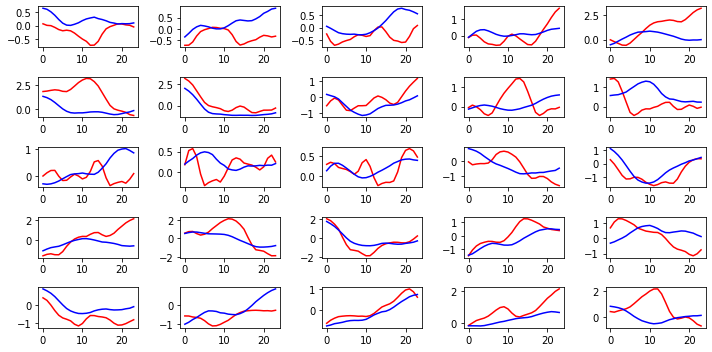

In [14]:
train(num_epochs=50)

In [94]:
model.load_state_dict(torch.load('models/basemodel_epoch_5.pt'))

<All keys matched successfully>

In [15]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [17]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
    data_list = [SST,T300,Ua,Va]
    SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

(20736, 4)


In [9]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [44]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [45]:
make_zip()

./result/test_0144-01-12.npy
